In [1]:
ENV["PYTHONPATH"] = "/home/shinaoka/sharehome/git/xfac/build/python"
using PyCall
xfacpy = pyimport("xfacpy")
using QuanticsTCI
using SparseIR
import SparseIR: valueim
using Plots
using ITensors
ITensors.disable_warn_order()

14

In [2]:
function tobins(i, nbit)
    @assert 1 ≤ i ≤ 2^nbit
    mask = 1 << (nbit-1)
    bin = ones(Int, nbit)
    for n in 1:nbit
        bin[n] = (mask & (i-1)) >> (nbit-n) + 1
        mask = mask >> 1
    end
    return bin
end

function frombins(bin)
    @assert all(1 .≤ bin .≤ 2)
    nbit = length(bin)
    i = 1
    tmp = 2^(nbit-1)
    for n in eachindex(bin)
        i += tmp * (bin[n] -1)
        tmp = tmp >> 1
    end
    return i
end

@assert frombins(tobins(4, 10)) == 4

In [3]:
beta = 100.0

ek(kx, ky) = 2*cos(kx) + 2*cos(ky)

v = FermionicFreq(1)
iv = valueim(v, beta)

gk(kx, ky) = 1 / (iv - ek(kx, ky))

function gkb(b)
    nbit = length(b) ÷ 2
    N = 2^nbit
    ikx = frombins(b[1:2:end])
    iky = frombins(b[2:2:end])
    @assert ikx ≤ N
    @assert iky ≤ N
    kx = 2π * (ikx - 1)/N
    ky = 2π * (iky - 1)/N
    return abs.(gk(kx, ky))
end

gkb (generic function with 1 method)

In [4]:
nbit = 9
N = 2^nbit

function gengkdata(gkb, nbit)
    gkdata = zeros(Float64, N, N)
    for ikx in 1:N, iky in 1:N
        bx = tobins(ikx, nbit)
        by = tobins(iky, nbit)
        b = collect(Iterators.flatten(zip(bx, by)))
        gkdata[ikx, iky] = gkb(b)
    end
    return gkdata
end

gkdata = gengkdata(gkb, nbit)
;

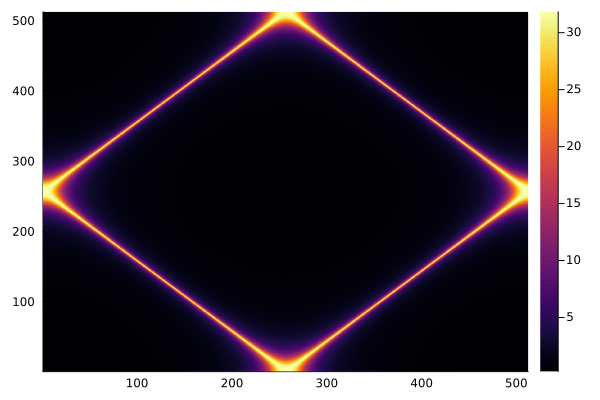

In [5]:
heatmap(gkdata)

In [6]:
firstpivot = ones(Int, 2*nbit)
@show firstpivot
qtt, ranks, errors = QuanticsTCI.qtt(
    b -> gkb(b .+ 1),
    2,
    firstpivot;
    cutoff=1e-5, maxiter=200
)
;

firstpivot = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
10	10	57.11981927241863
20	20	21.963757599246556
30	30	11.831077705023638
40	40	2.2452290417431304
50	50	1.2441954690637267
60	60	0.10368623324718212
70	70	0.013537712163725287
80	80	0.0037900480126357564
90	90	0.0004868045183358068
100	100	0.00012203139458517818
110	110	1.1738191287132334e-5


In [7]:
sitesx =  [Index(2, "Qubit,kx=$k") for k in 1:nbit]
sitesy =  [Index(2, "Qubit,ky=$k") for k in 1:nbit]
sites = collect(Iterators.flatten(zip(sitesx, sitesy)))
mps = QuanticsTCI.qtt_to_mps(qtt, sites)

MPS
[1] ((dim=2|id=397|"Qubit,kx=1"), (dim=2|id=232|"link"))
[2] ((dim=2|id=232|"link"), (dim=2|id=794|"Qubit,ky=1"), (dim=2|id=778|"link"))
[3] ((dim=2|id=778|"link"), (dim=2|id=102|"Qubit,kx=2"), (dim=4|id=887|"link"))
[4] ((dim=4|id=887|"link"), (dim=2|id=597|"Qubit,ky=2"), (dim=8|id=207|"link"))
[5] ((dim=8|id=207|"link"), (dim=2|id=654|"Qubit,kx=3"), (dim=16|id=837|"link"))
[6] ((dim=16|id=837|"link"), (dim=2|id=797|"Qubit,ky=3"), (dim=32|id=937|"link"))
[7] ((dim=32|id=937|"link"), (dim=2|id=744|"Qubit,kx=4"), (dim=64|id=169|"link"))
[8] ((dim=64|id=169|"link"), (dim=2|id=322|"Qubit,ky=4"), (dim=114|id=653|"link"))
[9] ((dim=114|id=653|"link"), (dim=2|id=614|"Qubit,kx=5"), (dim=114|id=875|"link"))
[10] ((dim=114|id=875|"link"), (dim=2|id=784|"Qubit,ky=5"), (dim=114|id=294|"link"))
[11] ((dim=114|id=294|"link"), (dim=2|id=160|"Qubit,kx=6"), (dim=114|id=630|"link"))
[12] ((dim=114|id=630|"link"), (dim=2|id=305|"Qubit,ky=6"), (dim=64|id=458|"link"))
[13] ((dim=64|id=458|"link"), (di

2 ^ (nbit / 2) = 22.627416997969522


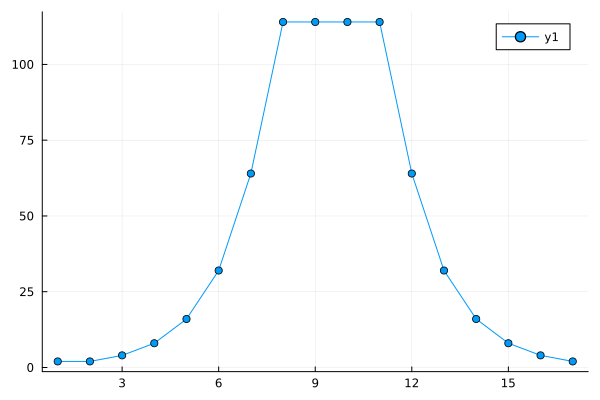

In [8]:
@show 2^(nbit/2)
plot(ITensors.dim.(linkinds(mps)), marker=:circle)

In [9]:
gkdata_reconst = reshape(Array(reduce(*, mps), [reverse(sitesx)..., reverse(sitesy)...]), N, N)
;

norm(gkdata_reconst .- gkdata) = 2.0513211814140786e-5
maximum(gkdata) = 31.830988618379067
maximum(abs, vec(gkdata_reconst .- gkdata)) = 2.753664834820313e-6


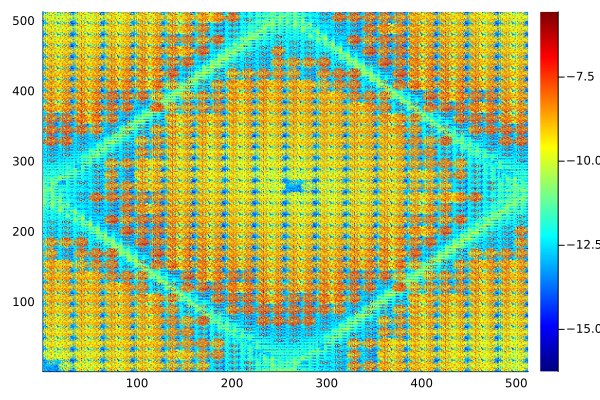

In [10]:
@show norm(gkdata_reconst .- gkdata)
p = plot(yscale=:log10, ylims=(1e-3, 1e+3))
@show maximum(gkdata)
@show maximum(abs, vec(gkdata_reconst .- gkdata))
#plot!(p, abs.(vec(gkdata_reconst .- gkdata)))
heatmap(log10.(abs.(gkdata_reconst .- gkdata)), c=:jet)

In [11]:
mps2 = MPS(ITensor(gkdata, [reverse(sitesx)..., reverse(sitesy)...]), sites; cutoff=1e-18)

MPS
[1] ((dim=2|id=397|"Qubit,kx=1"), (dim=2|id=465|"Link,n=1"))
[2] ((dim=2|id=465|"Link,n=1"), (dim=2|id=794|"Qubit,ky=1"), (dim=2|id=64|"Link,n=2"))
[3] ((dim=2|id=64|"Link,n=2"), (dim=2|id=102|"Qubit,kx=2"), (dim=4|id=95|"Link,n=3"))
[4] ((dim=4|id=95|"Link,n=3"), (dim=2|id=597|"Qubit,ky=2"), (dim=8|id=755|"Link,n=4"))
[5] ((dim=8|id=755|"Link,n=4"), (dim=2|id=654|"Qubit,kx=3"), (dim=16|id=698|"Link,n=5"))
[6] ((dim=16|id=698|"Link,n=5"), (dim=2|id=797|"Qubit,ky=3"), (dim=32|id=316|"Link,n=6"))
[7] ((dim=32|id=316|"Link,n=6"), (dim=2|id=744|"Qubit,kx=4"), (dim=57|id=380|"Link,n=7"))
[8] ((dim=57|id=380|"Link,n=7"), (dim=2|id=322|"Qubit,ky=4"), (dim=74|id=758|"Link,n=8"))
[9] ((dim=74|id=758|"Link,n=8"), (dim=2|id=614|"Qubit,kx=5"), (dim=97|id=401|"Link,n=9"))
[10] ((dim=97|id=401|"Link,n=9"), (dim=2|id=784|"Qubit,ky=5"), (dim=102|id=370|"Link,n=10"))
[11] ((dim=102|id=370|"Link,n=10"), (dim=2|id=160|"Qubit,kx=6"), (dim=114|id=547|"Link,n=11"))
[12] ((dim=114|id=547|"Link,n=11"), (d

In [12]:
gkdata_reconst2 = reshape(Array(reduce(*, mps2), [reverse(sitesx)..., reverse(sitesy)...]), N, N)

512×512 Matrix{Float64}:
 0.249992  0.250002  0.25003   0.250077  …  0.250077  0.25003   0.250002
 0.250002  0.250011  0.250039  0.250086     0.250086  0.250039  0.250011
 0.25003   0.250039  0.250068  0.250115     0.250115  0.250068  0.250039
 0.250077  0.250086  0.250115  0.250162     0.250162  0.250115  0.250086
 0.250143  0.250152  0.250181  0.250228     0.250228  0.250181  0.250152
 0.250228  0.250237  0.250265  0.250313  …  0.250313  0.250265  0.250237
 0.250331  0.250341  0.250369  0.250416     0.250416  0.250369  0.250341
 0.250454  0.250463  0.250492  0.250539     0.250539  0.250492  0.250463
 0.250596  0.250605  0.250633  0.250681     0.250681  0.250633  0.250605
 0.250756  0.250766  0.250794  0.250841     0.250841  0.250794  0.250766
 0.250936  0.250945  0.250974  0.251021  …  0.251021  0.250974  0.250945
 0.251135  0.251144  0.251173  0.25122      0.25122   0.251173  0.251144
 0.251352  0.251362  0.251391  0.251438     0.251438  0.251391  0.251362
 ⋮                        

norm(gkdata_reconst2 .- gkdata) = 5.461582646611485e-6
maximum(abs, vec(gkdata_reconst2 .- gkdata)) = 1.5208199144467471e-7


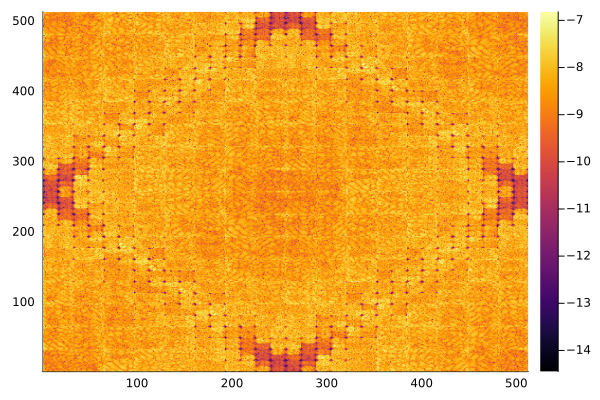

In [13]:
@show norm(gkdata_reconst2 .- gkdata)
@show maximum(abs, vec(gkdata_reconst2 .- gkdata))
heatmap(log10.(abs.(gkdata_reconst2 .- gkdata)))